# Udacity Advance Lane Lines Project

In [114]:
# Place for adding all includes
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

global imshow_enable = 0

%matplotlib inline

In [115]:
# Try to plot some images here

curr_dir = os.getcwd()

calib_dir = os.path.join(curr_dir, "camera_cal")

calib_images = os.listdir(calib_dir)
print ("Total number of images: %s" % (len(calib_images)))

if imshow_enable == 1:
    plt.figure(figsize=(20, 10))

    for i in range(0, len(calib_images)):
        each = calib_images[i]
        file_name = os.path.join(calib_dir, each)

        plt.subplot(4, 5, i + 1)
        image = cv2.imread(file_name)
        plt.imshow(image)
    plt.show()

Total number of images: 20


### Project pipeline

Pipeline algorithm:

- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform

### Camera Calibration

In [116]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# Code referred from https://github.com/udacity/CarND-Camera-Calibration

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


In [117]:
import pickle
%matplotlib inline

def plot_images(img1, img2, img1_title, img2_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(img1_title, fontsize=15)
    ax2.imshow(img2)
    ax2.set_title(img2_title, fontsize=15)


def undistort_image(img):
    # Test undistortion on an image
    
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

file_name = "camera_cal/calibration1.jpg"
image = cv2.imread(file_name)
undistorted_img = undistort_image(image)
if imshow_enable == 1:
    plot_images(image, undistorted_img, "Original Image", "Undistorted Image")

## Perspective transform


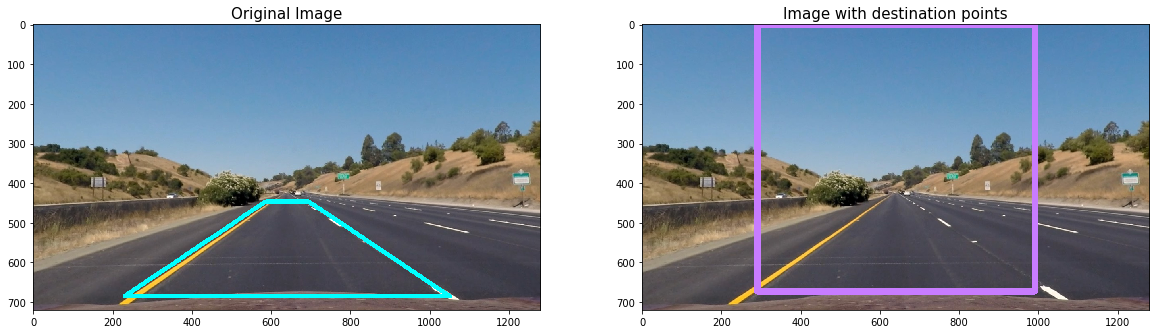

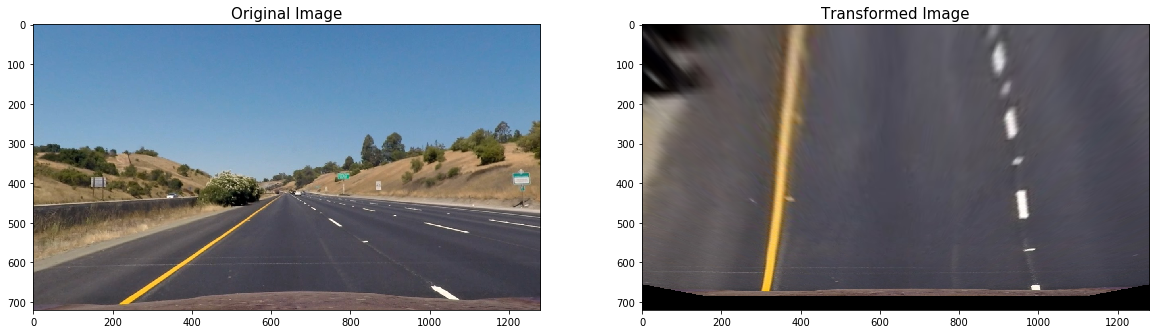

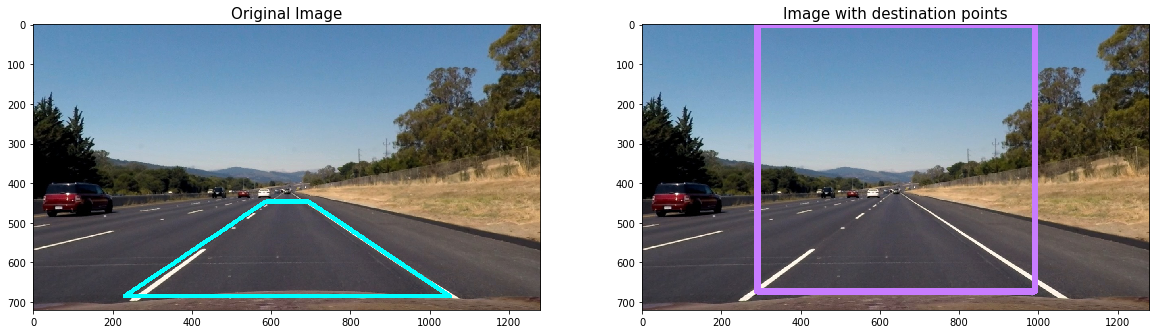

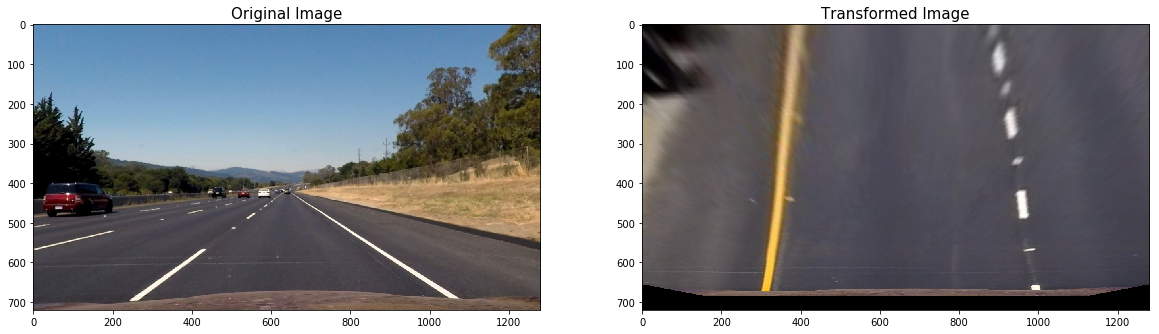

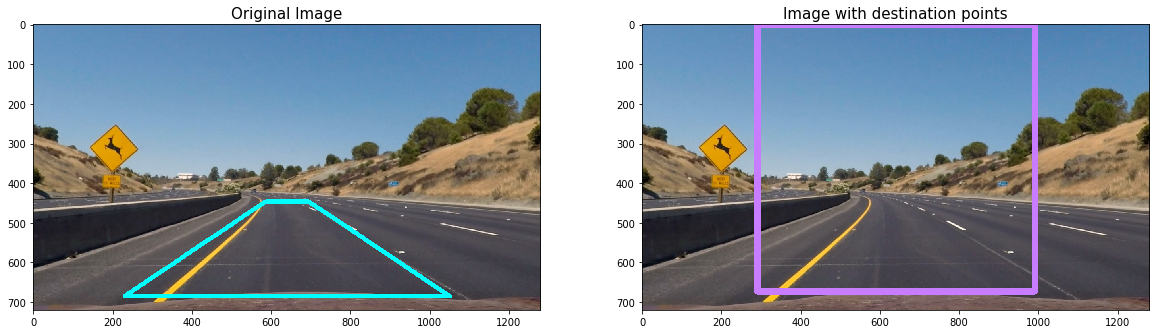

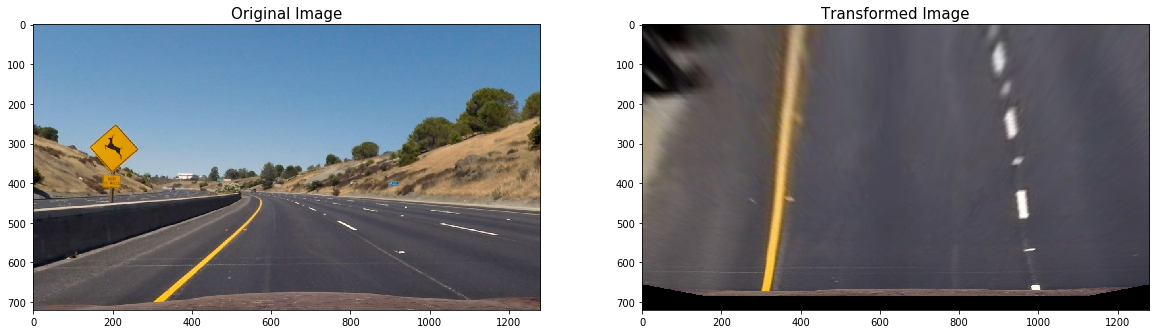

In [127]:
def get_source_img_wrap(image):
    image_size = (image.shape[0], image.shape[1])
    image_height = image.shape[0]
    image_width = image.shape[1]

    trap_y = (image_height / 2) + 86
    trap_x = (image_width / 2)
    top_offset_x = 54
    bottom_offset_y = 60
    bottom_offset_x = 230

    left_top = [trap_x - top_offset_x + 10, trap_y]
    left_bottom = [bottom_offset_x + 24, image_height - bottom_offset_y]
    right_top = [trap_x + top_offset_x - 10, trap_y]
    right_bottom = [image_width - bottom_offset_x, image_height - bottom_offset_y]
    
    print ("Image height: %s, width: %s, left top: %s, left bottom: %s, right bottom: %s, right top: %s" %
        (image_height, image_width, left_top, left_bottom, right_bottom, right_top))

    pts = np.array([ left_top, left_bottom, right_bottom, right_top], np.int32)
    pts = pts.reshape((-1,1,2))
    
    return pts

def get_destination_img_wrap(image):
    image_size = (image.shape[0], image.shape[1])
    image_height = image.shape[0]
    image_width = image.shape[1]

    mask_x = image_width/2
    mask_x_offset = 350
    mask_y_offset = 70

    left_top = [ mask_x - mask_x_offset, 0]
    left_bottom = [mask_x - mask_x_offset, image_height - mask_y_offset]
    right_top = [mask_x + mask_x_offset, 0]
    right_bottom = [mask_x + mask_x_offset, image_height - mask_y_offset]
    print ("Image height: %s, width: %s, left top: %s, left bottom: %s, right bottom: %s, right top: %s" %
        (image_height, image_width, left_top, left_bottom, right_bottom, right_top))

    pts = np.array([ left_top, left_bottom, right_bottom, right_top], np.int32)
    pts = pts.reshape((-1,1,2))
    return pts

def get_src_dst(image):
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]

    img_size = (image.shape[1], image.shape[0])

    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    return src, dst

def get_warp_perspective(image, src_pts, dst_pts, image_size):
    src_pts = np.float32(src_pts.tolist())
    dst_pts = np.float32(dst_pts.tolist())

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_image = cv2.warpPerspective(img_copy2, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped_image

def perspective_transform(img_src):
    img_dst = img_src.copy()
    
#     src_pts = get_source_img_wrap(img_src)
#     dst_pts = get_destination_img_wrap(img_dst)
    src, dst = get_src_dst(img)
    
    warped = get_warp_perspective(img_src, src_pts, dst_pts, (img_src.shape[1], img_src.shape[0]))  
    return warped

def show_src_dst_image_warps(img):
    img_src = img.copy()
    img_dst = img_src.copy()
    
#     src_pts = get_source_img_wrap(img_src)
#     dst_pts = get_destination_img_wrap(img_dst)
    src, dst = get_src_dst(img)
    
    src_img = cv2.polylines(img_src, [src_pts], True, (0,255,255), 10)
    dst_img = cv2.polylines(img_dst, [dst_pts], True, (200,124,255), 15)
    if imshow_enable == 1:
        plot_images(src_img, dst_img, "Original Image" , "Image with destination points")

    
# file_name = "./test_images/straight_lines1.jpg"

file_list = [ "./test_images/straight_lines1.jpg", "./test_images/straight_lines2.jpg",
             "./test_images/test2.jpg"]

imshow_enable = 1

for file_name in file_list:    
    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = undistort_image(image)
    show_src_dst_image_warps(image)

    warped_img = perspective_transform(image)
    if imshow_enable == 1:
        plot_images(image, warped_img, "Original Image", "Transformed Image")

